[View in Colaboratory](https://colab.research.google.com/github/guitar79/OA-2018/blob/master/07_2_Drawing_H_R_Diagram_of_Hipparcos_Catalogue.ipynb)

**Construction of Hertzsprung-Russell diagrams in Python**

* 이 자료는 Hipparcos Catalogue를 이용하여 HR Diagram을 그리는 교수학습자료이다.

* 이 자료는 아래 자료를 약간 번역하고, python3 환경에서 돌아가도록 수정하여 작성하였다.

* http://balbuceosastropy.blogspot.com/2014/03/construction-of-hertzsprung-russell.html

* package를 쉽게 설치하기 위해 Anaconda 사용을 권장한다.

* 경기과학고등학교 관측천문학 강좌를 위해 만들었으며 라이센스는 다음을 따릅니다.
![CCL](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-nc.eu.svg)


#Introductons

**Theory**

Some relevant facts in the development of a Hertsprung-Russel diagram (H-R diagram in short) are:

*  On the one hand there is a relationship between the absolute magnitude of a star and its luminosity, which has been described in this post: The color of celestial objects: part I

*  There is also a relationship between the spectral class of the star (O B A F G K M), its surface temperature and its color index (eg. B-V). This relationship between color index and temperature can also be seen in the previous post. Regarding the relationship between spectral classes and surface temperatures, you can read my post The color of celestial objects: part II

*  The purpose of the H-R diagram is to show the relationship between both groups of magnitudes. The "classic" H-R diagram shows the spectral class of the stars (or the corresponding color index B-V) on the horizontal axis and the absolute magnitudes on the vertical axis.

*  The position of a star in the H-R diagram tells us something about its characteristics. Thus for example if a star has a spectral class indicating a "cold" surface temperature (for example classes K or M), but its absolute magnitude / luminosity is high, this indicates that the star has a large surface, whereby the big radiative surface "compensates" the low intensity of the radiation due to its low temperature. Ie it would be a "giant" star or "supergiant". As the color indices corresponding to cold temperatures tend to red, we would speak for instance of "red giants".

**The HIPPARCOS catalog**

The biggest difficulty to build an H-R diagram is to determine the luminosity or absolute magnitude of the stars, as this involves knowing their distances. In this sense, the catalog of celestial objects SDSS I've been using so far in previous posts is not the most suitable because its main purpose is the photometry of extragalactic objects, providing little information of stars in our galaxy, and certainly lacking accurate information on the distance that separates us from them.

For this reason, the catalog of stars that we will use is HIPPARCOS, given that the priomordial objective of this mission was precisely to make accurate measurements of about 120000 stars. Furthermore, the information in this catalog includes the spectral class of the vast majority of these objects, so it is the most suitable source that we can use to make an H-R diagram.

A description of the fields in the catalog can be downloaded in pdf format at the following page: Hipparcos Overview. In particular, for this post, we are interested in the following fields:

*  H1 Identifier (HIP)
*  H5 V Johnson magnitude (Vmag)
*  H11 Trigonometric parallax, expressed in units of milliarcsec (Plx)
*  H37 Colour index (B-V)
*  H76 Spectral type (SpType)

The absolute magnitudes can be calculated from the values of V. For this you can use the relationship between the absolute magnitude $M$, the apparent magnitude $m$ and the parallax $p$ parallax in arcseconds. 

> $M=m+5(1+log_{10}p)$

If parallax is expressed in milliarcseconds (Plx), and taking as apparent magnitude the value V in the catalog, we obtain:

> $M=V_{mag}+5 (1+log_{10} \dfrac{Plx}{1000})$

That once simplified gives:

> $M=V_{mag}+5 (log_{10} \dfrac{Plx}{100})$

# Processing data

**Downloading data for H-R diagram**

Strasbourg astronomical Data Center (CDS)로부터 the catalog I/239 자료를 다운받기 위해서 VizieR Search Page (http://vizier.u-strasbg.fr/viz-bin/VizieR-3?-source=I/239/hip_main) 에 접속한다. 

field 중에서 (HIP, Vmag, Plx, BV, SpType)만 선택하고, 왼쪽 메뉴에서 "Preferences" 선택, "unlimited" , "; -Separated Values", "Submit" 버튼을 누르면 약 3.8MB 크기의 자료가 다운받아 진다. text editor로 열어보면 약 118322개의 자료가 들어있다.

**DataFrame with the data**

pandas의 dataframe으로 자료를 처리해 보자.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

#Now I will read the file creating a Pandas DataFrame:
filename = 'I_239_selection.tsv'
df = pd.read_table(filename, skiprows=43, sep=';', header=None, index_col=0,
                   names = ['HIP', 'Vmag', 'Plx', 'B-V', 'SpType'],
                   skipfooter=1, engine='python')

df의 shape,  head, tail을 보자.

In [2]:
print('***shape of the dataframe***')
print(df.shape)

print('')
print('***head of the dataframe***')
print(df.head())

print('')
print('***tail of the dataframe***')
print(df.tail())

***shape of the dataframe***
(118218, 4)

***head of the dataframe***
      Vmag      Plx     B-V SpType
HIP                               
1     9.10     3.54   0.482     F5
2     9.27    21.90   0.999    K3V
3     6.61     2.81  -0.019     B9
4     8.06     7.75   0.370    F0V
5     8.55     2.87   0.902  G8III

***tail of the dataframe***
         Vmag      Plx     B-V SpType
HIP                                  
118318   6.99     1.92   1.595     K2
118319   8.23    10.63   0.639    G2V
118320   7.59     5.00   0.999     K0
118321   9.20    19.22   0.698    G5V
118322   4.49     8.71  -0.075   B9IV


df의 정보를 보자. count 값을 보면 데이터 행의 숫자인 118218보다 데이터 갯수가 적은 것을 볼 수 있다. 

In [3]:
print('***describe about the dataframe***')
print(df.describe())

***describe about the dataframe***
          Vmag      Plx     B-V  SpType
count   118218   118218  118218  115184
unique    1127     5617    2437    4124
top       8.69                       K0
freq       504      263    1281    8570


데이터가 없는 값을 'nan' 으로 넣어주자.

In [4]:
#python3로 수정하였음.
df_clean = df.apply(lambda x: x.str.strip()).replace('', np.nan)

#python2에서는 
#df_clean = df.applymap(lambda x: np.nan if isinstance(x, basestring) and x.isspace() else x)

print('***describe about df_clean***')
print(df_clean.describe())

***describe about df_clean***
          Vmag     Plx     B-V  SpType
count   118217  117955  116937  115184
unique    1126    5616    2436    4124
top       8.69    2.93   1.000      K0
freq       504     183     317    8570


'NaN' 값이 있는 raw를 지워야 겠다.

In [5]:
df_clean= df_clean.dropna()
print('***describe about df_clean after NaN value removed***')
print(df_clean.describe())

print('')
print('***shape of the df_clean***')
print(df_clean.shape)

print('')
print('***head of the df_clean***')
print(df_clean.head())

***describe about df_clean after NaN value removed***
          Vmag     Plx     B-V  SpType
count   114472  114472  114472  114472
unique    1072    5361    2426    4070
top       8.69    2.93   1.000      K0
freq       502     182     308    8537

***shape of the df_clean***
(114472, 4)

***head of the df_clean***
     Vmag    Plx     B-V SpType
HIP                            
1    9.10   3.54   0.482     F5
2    9.27  21.90   0.999    K3V
3    6.61   2.81  -0.019     B9
4    8.06   7.75   0.370    F0V
5    8.55   2.87   0.902  G8III


이제 df_clean 으로 계산을 할 것이다. 
위의 계산식에 의거하여 계산하기 위하여 'Vmag'', 'Plx', 'B-V' column의 data type을 string에서 numeric value로 바꾸어 주자.
그리고 절대등급 $M_v$ 를 계산하여 column에 추가해 보자.


In [6]:
# converting them from strings to numeric values
df_clean['Vmag'] = df_clean['Vmag'].astype(np.float)
df_clean['Plx'] = df_clean['Plx'].astype(np.float)
df_clean['B-V'] = df_clean['B-V'].astype(np.float)

# Add a new column with the absolute magnitude
df_clean['M_V'] = df_clean['Vmag'] + 5 * np.log10(df_clean['Plx']/100.)

print('***describe about df_clean***')
print(df_clean.describe())

print('')
print('***head of the df_clean***')
print(df_clean.head())

***describe about df_clean***
                Vmag            Plx            B-V           M_V
count  114472.000000  114472.000000  114472.000000  1.107700e+05
mean        8.297756       7.105059       0.702421          -inf
std         1.248646      11.063782       0.490229           NaN
min        -1.440000     -35.100000      -0.400000          -inf
25%         7.610000       2.520000       0.341000  2.576435e-01
50%         8.400000       4.580000       0.605000  1.504575e+00
75%         9.070000       8.260000       1.075000  3.050985e+00
max        13.610000     772.330000       5.460000  1.544901e+01

***head of the df_clean***
     Vmag    Plx    B-V SpType       M_V
HIP                                     
1    9.10   3.54  0.482     F5  1.845016
2    9.27  21.90  0.999    K3V  5.972221
3    6.61   2.81 -0.019     B9 -1.146468
4    8.06   7.75  0.370    F0V  2.506509
5    8.55   2.87  0.902  G8III  0.839409


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


Next let's study the spectral types present in the dataframe. Really the only information needed at this time from the SpType column are the first two characters. Furthermore we will be only interested in those cases where the first character is alphabetic and the second is a number, like G8 or F5. After removing the anomalies, a new column is created with only the first two characters:

In [7]:
# Rows that do not meet the condition alpha + num are eliminated
f = lambda s: (len(s) >= 2)  and (s[0].isalpha()) and (s[1].isdigit())
i  = df_clean['SpType'].apply(f)
df_clean = df_clean[i]

# A new column is created with the first two characters from 'SpType'
f = lambda s: s[0:2]
df_clean['SpType2'] = df_clean['SpType'].apply(f)

print('')
print('***shape of the df_clean***')
print(df_clean.shape)

print('')
print('***head of the df_clean***')
print(df_clean.head())


***shape of the df_clean***
(111562, 6)

***head of the df_clean***
     Vmag    Plx    B-V SpType       M_V SpType2
HIP                                             
1    9.10   3.54  0.482     F5  1.845016      F5
2    9.27  21.90  0.999    K3V  5.972221      K3
3    6.61   2.81 -0.019     B9 -1.146468      B9
4    8.06   7.75  0.370    F0V  2.506509      F0
5    8.55   2.87  0.902  G8III  0.839409      G8


spectral class에 따라 분류해 보자.

In [8]:
f = lambda s: s[0]
clases = df_clean['SpType'].map(f)

print('***count number each class in df_clean***')
print(clases.value_counts())

***count number each class in df_clean***
K    31578
F    25201
G    22213
A    17651
B    10281
M     4212
O      256
C       82
N       48
R       23
S       17
Name: SpType, dtype: int64


spectral class에서 OBAFGKM 을 제외한 C, N, R and S를 지워야 겠다.

In [9]:
f = lambda s: s[0] in 'OBAFGKM'
df_clean = df_clean[df_clean['SpType'].map(f)]

f = lambda s: s[0]
clases = df_clean['SpType'].map(f)

print('***count number each class in df_clean***')
print(clases.value_counts())

***count number each class in df_clean***
K    31578
F    25201
G    22213
A    17651
B    10281
M     4212
O      256
Name: SpType, dtype: int64


The purpose is to make a graph where on the horizontal axis are the spectral classes included in the Morgan-Keenan system (MKK) "OBAFGKM", followed by a digit 0-9. In addition we want that the spectral classes appear ordered precisely in this order (B5 before A0...). So I'm going to replace the letters by digits in ascending sequence in the SpType2 column, in order to sort by that column.


In [10]:
f = lambda s: s[0] in 'OBAFGKM'
df_clean = df_clean[df_clean['SpType'].map(f)]

f = lambda s: s[0]
clases = df_clean['SpType'].map(f)

orden = {'O':'0', 'B':'1', 'A':'2', 'F':'3', 'G':'4', 'K':'5', 'M':'6'}
f = lambda s: orden[s[0]]+s[1]
df_clean['SpType2'] = df_clean['SpType2'].apply(f)

print('')
print('***head of the df_clean***')
print(df_clean.head())


***head of the df_clean***
     Vmag    Plx    B-V SpType       M_V SpType2
HIP                                             
1    9.10   3.54  0.482     F5  1.845016      35
2    9.27  21.90  0.999    K3V  5.972221      53
3    6.61   2.81 -0.019     B9 -1.146468      19
4    8.06   7.75  0.370    F0V  2.506509      30
5    8.55   2.87  0.902  G8III  0.839409      48


# Chart plot

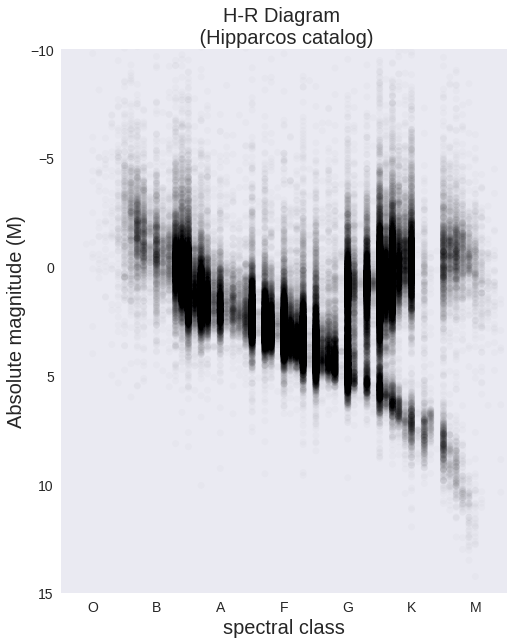

In [11]:
fig, ax = plt.subplots(figsize=(8,10))

ax.set_xlim(0, 70)
ax.set_ylim(15, -10)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('spectral class')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude (M)')
ax.yaxis.label.set_fontsize(20)

ax.scatter(df_clean['SpType2'].astype(np.int), df_clean['M_V'],
           s=50, edgecolors='none', alpha=0.015, c='k')
ax.set_xticks(range(5,75,10))
ax.set_xticklabels(['O', 'B', 'A', 'F', 'G', 'K', 'M'])
ax.tick_params(axis='both', labelsize=14)

The diagram above is not very satisfactory, in the sense that as the horizontal axis correspond to a discrete set of values (the different spectral types), vertical stripes are formed by accumulation of observations on these values. It would be preferable to use a continuous scale of decimal values. Therefore we are going to repeat the plot, this time using the color index B-V instead of the spectral classes. Furthermore, it will show that both diagrams have the same shape, confirming the relationship between spectral classes and color indexes.

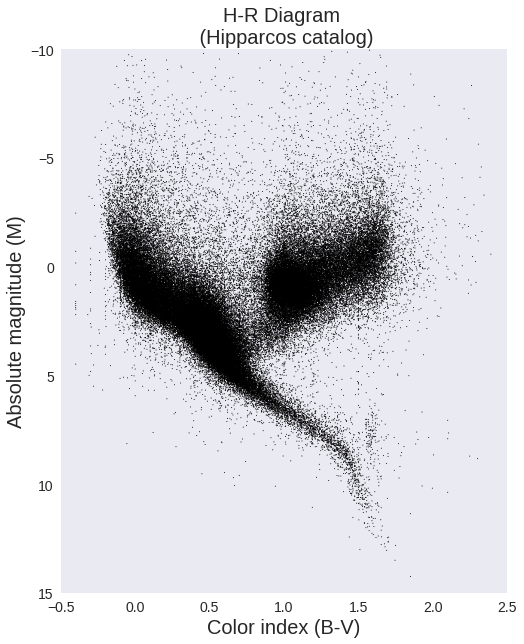

In [12]:
fig, ax = plt.subplots(figsize=(8,10))

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -10)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index (B-V)')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude (M)')
ax.yaxis.label.set_fontsize(20)

ax.scatter(df_clean['B-V'], df_clean['M_V'],
           #s=50, edgecolors='none', alpha=0.015, c='k')
           s=1, edgecolors='none', c='k')

ax.tick_params(axis='both', labelsize=14)

# Luminosity classes

In addition to the spectral type OBAFGKM, many stars in the Hipparcos catalog contain, in the field SpType, the luminosity class coded with the Roman numerals I to VII, that indicate the type of star in question. You can read an explanation of this classification system in the Wikipedia: Stellar classification

So let's analyze the presence of these luminosity classes in the HIPPARCOS catalog:

In [13]:
f = lambda s: 'VII' in s
b = df_clean['SpType'].map(f)
print ("Class VII: white dwarfs, there are %d stars" %sum(b))

f = lambda s: ('VI' in s) and ('VII' not in s)
b = df_clean['SpType'].map(f)
print ("Class VI: subdwarfs, there are %d stars" %sum(b))

f = lambda s: ('V' in s) and ('VI' not in s) and ('IV' not in s)
b = df_clean['SpType'].map(f)
print ("Class V: main-sequence, there are %d stars" %sum(b))

f = lambda s: 'IV' in s
b = df_clean['SpType'].map(f)
print ("Class IV: subgiants, there are %d stars" %sum(b))

f = lambda s: 'III' in s
b = df_clean['SpType'].map(f)
print ("Class III: giants, there are %d stars" %sum(b))

f = lambda s: ('II' in s) and ('III' not in s) and ('VII' not in s)
b = df_clean['SpType'].map(f)
print ("Class II:  bright giants, there are %d stars" %sum(b))

f = lambda s: ('I' in s) and ('II' not in s) and ('V' not in s)
b = df_clean['SpType'].map(f)
print ("Class I: supergiants, there are %d stars" %sum(b))

Class VII: white dwarfs, there are 1 stars
Class VI: subdwarfs, there are 16 stars
Class V: main-sequence, there are 24683 stars
Class IV: subgiants, there are 7955 stars
Class III: giants, there are 22519 stars
Class II:  bright giants, there are 1239 stars
Class I: supergiants, there are 937 stars


As you can see below, about half of the stars in the catalog have no luminosity class encoded in the SpType field:

In [14]:
f = lambda s: ('I' not in s) and ('V' not in s)
b = df_clean['SpType'].map(f)

print (sum(b))

55605


However, there's yet a significant number of entries in the catalog that do contain information of the stellar class, so it makes sense to show the position of each of these luminosity classes in the H-R diagram

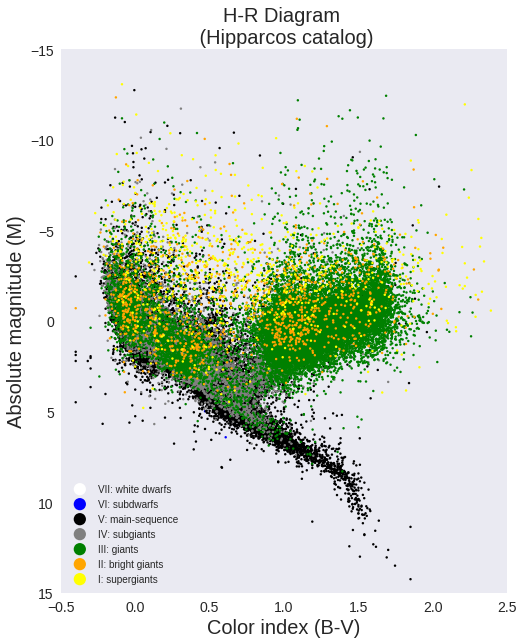

In [15]:
def plot_lum_class(b,c, label):
    ''' b: boolean Series to make the selection
        c: Color
        label: for the legend
    '''
    x = df_clean['B-V'][b]
    y = df_clean['M_V'][b]
    ax.scatter(x, y, c = c, s=6, edgecolors='none', label = label)

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index (B-V)')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute magnitude (M)')
ax.yaxis.label.set_fontsize(20)

f = lambda s: 'VII' in s
b = df_clean['SpType'].map(f)
plot_lum_class(b,'white', 'VII: white dwarfs')

f = lambda s: ('VI' in s) and ('VII' not in s)
b = df_clean['SpType'].map(f)
plot_lum_class(b,'blue', 'VI: subdwarfs')

f = lambda s: ('V' in s) and ('VI' not in s) and ('IV' not in s)
b = df_clean['SpType'].map(f)
plot_lum_class(b,'black', 'V: main-sequence')

f = lambda s: 'IV' in s
b = df_clean['SpType'].map(f)
plot_lum_class(b,'grey', 'IV: subgiants')

f = lambda s: 'III' in s
b = df_clean['SpType'].map(f)
plot_lum_class(b,'green', 'III: giants')

f = lambda s: ('II' in s) and ('III' not in s) and ('VII' not in s)
b = df_clean['SpType'].map(f)
plot_lum_class(b,'orange', 'II: bright giants')

f = lambda s: ('I' in s) and ('II' not in s) and ('V' not in s)
b = df_clean['SpType'].map(f)
plot_lum_class(b,'yellow', 'I: supergiants')

ax.tick_params(axis='both', labelsize=14)
legend = ax.legend(scatterpoints=1, markerscale = 5, shadow=True)
frame = legend.get_frame()

#frame.set_facecolor('0.90')